In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('kospi.csv')

In [3]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-30,2183.489990,2206.199951,2177.879883,2206.199951,2206.199951,480400
1,2019-01-31,2222.879883,2222.879883,2201.219971,2204.850098,2204.850098,545200
2,2019-02-01,2211.929932,2218.780029,2201.409912,2203.459961,2203.459961,479400
3,2019-02-07,2215.770020,2215.790039,2196.770020,2203.419922,2203.419922,427800
4,2019-02-08,2192.010010,2192.479980,2171.959961,2177.050049,2177.050049,391000


In [4]:
scaler = MinMaxScaler()
df[['Open','High','Low','Close','Volume']] = scaler.fit_transform(df[['Open','High','Low','Close','Volume']])

In [5]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-30,0.722898,0.732351,0.745525,0.759235,2206.199951,0.242113
1,2019-01-31,0.763058,0.750069,0.769089,0.757866,2204.850098,0.274771
2,2019-02-01,0.751894,0.745714,0.769280,0.756456,2203.459961,0.241609
3,2019-02-07,0.755809,0.742538,0.764596,0.756415,2203.419922,0.215603
4,2019-02-08,0.731584,0.717777,0.739548,0.729669,2177.050049,0.197057


In [6]:
X = df[['Open', 'High','Low','Volume']].values
y = df['Close'].values

In [7]:
def seq_data(x, y, sequence_length):
  
  x_seq = []
  y_seq = []
  for i in range(len(x) - sequence_length):
    x_seq.append(x[i: i+sequence_length])
    y_seq.append(y[i+sequence_length])
    
  return torch.FloatTensor(x_seq), torch.FloatTensor(y_seq).view([-1,1])

In [8]:
len(df)

431

In [12]:
split = 200 
sequence_length = 10

x_seq, y_seq = seq_data(X, y, sequence_length)

x_train_seq = x_seq[:split]
y_train_seq = y_seq[:split]
x_test_seq = x_seq[split:]
y_test_seq = y_seq[split:]
print(x_train_seq.size(), y_train_seq.size())
print(x_test_seq.size(), y_test_seq.size())

torch.Size([200, 10, 4]) torch.Size([200, 1])
torch.Size([221, 10, 4]) torch.Size([221, 1])


In [13]:
train = torch.utils.data.TensorDataset(x_train_seq, y_train_seq)
test = torch.utils.data.TensorDataset(x_test_seq, y_test_seq)
# shuffle 방지 
batch_size = 20
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=batch_size, shuffle=False)

In [32]:
input_size = x_seq.size(2)
num_layers = 2
hidden_size = 5

In [33]:
input_size

4

In [ ]:
timesteps = 10 
input_size = 4 
hidden_size = 5

inputs = np.random.random((timesteps, input_size)) # 입력에 해당되는 2D 텐서

hidden_state_t = np.zeros((hidden_size,))

Wx = np.random.random((hidden_size, input_size))  # (8, 4)크기의 2D 텐서 생성. 입력에 대한 가중치.
Wh = np.random.random((hidden_size, hidden_size)) # (8, 8)크기의 2D 텐서 생성. 은닉 상태에 대한 가중치.
b = np.random.random((hidden_size,))

In [43]:
class VanillaRNN(nn.Module):

  def __init__(self, input_size, hidden_size, sequence_length, num_layers):
    super(VanillaRNN, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
    self.fc = nn.Sequential(nn.Linear(hidden_size * sequence_length, 1), nn.Tanh())

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size) 
    out, hn = self.rnn(x, h0) # out: RNN의 마지막 레이어로부터 나온 output feature 를 반환한다. hn: hidden state를 반환한다.
    out = out.reshape(out.shape[0], -1) # many to many 전략
    out = self.fc(out)
    return out
model = VanillaRNN(input_size=input_size,
                   hidden_size=hidden_size,
                   sequence_length=sequence_length,
                   num_layers=num_layers,
                   )

In [ ]:
class TimeRNN:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None

        self.h, self.dh = None, None
        self.stateful = stateful

    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        D, H = Wx.shape

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')

        for t in range(T):
            layer = RNN(*self.params)
            self.h = layer.forward(xs[:, t, :], self.h)
            hs[:, t, :] = self.h
            self.layers.append(layer)

        return hs

    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D, H = Wx.shape

        dxs = np.empty((N, T, D), dtype='f')
        dh = 0
        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh = layer.backward(dhs[:, t, :] + dh)
            dxs[:, t, :] = dx

            for i, grad in enumerate(layer.grads):
                grads[i] += grad

        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh

        return dxs

    def set_state(self, h):
        self.h = h

    def reset_state(self):
        self.h = None

In [44]:
criterion = nn.MSELoss()

lr = 1e-3
num_epochs = 200
optimizer = optim.Adam(model.parameters(), lr=lr)

In [45]:
loss_graph = [] # 그래프 그릴 목적인 loss.
n = len(train_loader)

for epoch in range(num_epochs):
  running_loss = 0.0

  for data in train_loader:

    seq, target = data # 배치 데이터.
    out = model(seq)   # 모델에 넣고,
    loss = criterion(out, target) # output 가지고 loss 구하고,

    optimizer.zero_grad() # 
    loss.backward() # loss가 최소가 되게하는 
    optimizer.step() # 가중치 업데이트 해주고,
    running_loss += loss.item() # 한 배치의 loss 더해주고,

  loss_graph.append(running_loss / n) # 한 epoch에 모든 배치들에 대한 평균 loss 리스트에 담고,
  if epoch % 100 == 0:
    print('[epoch: %d] loss: %.4f'%(epoch, running_loss/n))

[epoch: 0] loss: 0.1821
[epoch: 100] loss: 0.0011


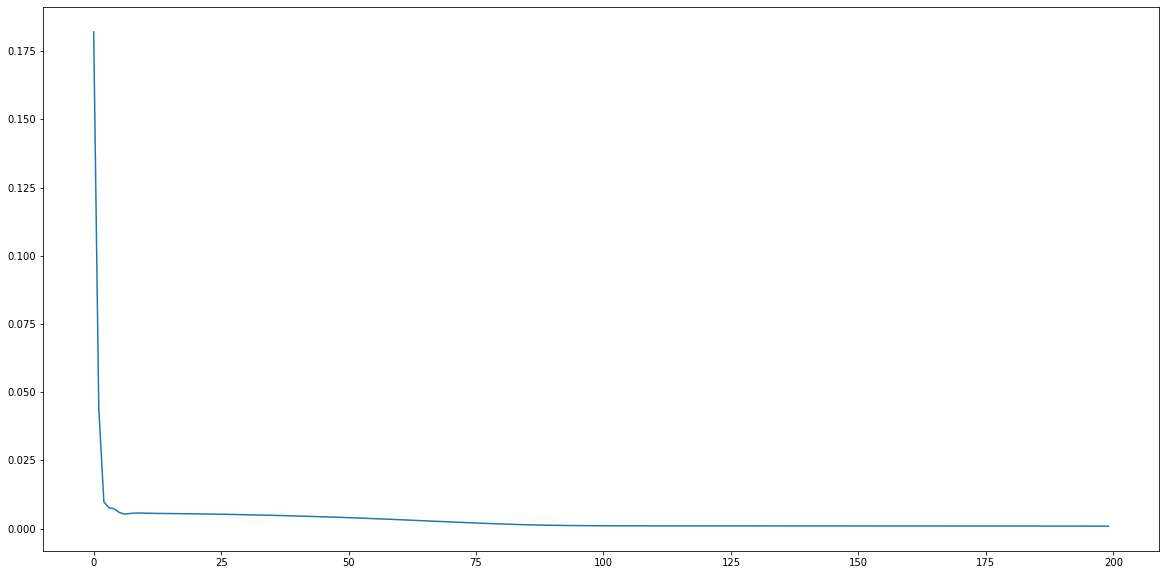

In [46]:
plt.figure(figsize=(20,10))
plt.plot(loss_graph)
plt.show()

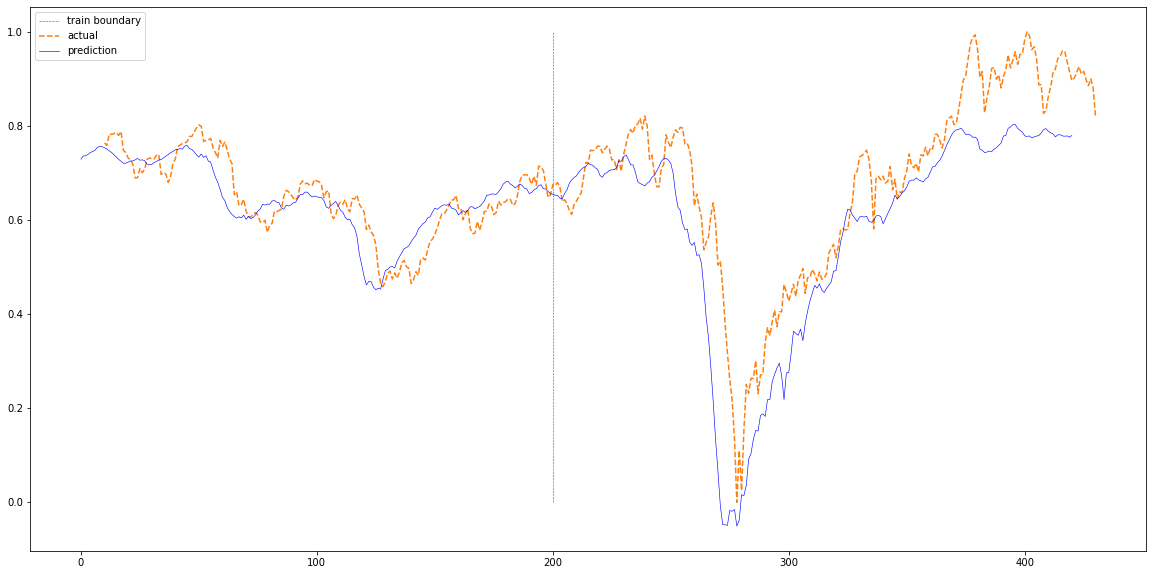

In [47]:
def plotting(train_loader, test_loader, actual):
  with torch.no_grad():
    train_pred = []
    test_pred = []

    for data in train_loader:
      seq, target = data
      out = model(seq)
      train_pred += out.cpu().numpy().tolist()

    for data in test_loader:
      seq, target = data
      out = model(seq)
      test_pred += out.cpu().numpy().tolist()
      
  total = train_pred + test_pred
  plt.figure(figsize=(20,10))
  plt.plot(np.ones(100)*len(train_pred), np.linspace(0,1,100), '--', linewidth=0.6)
  plt.plot(actual, '--')
  plt.plot(total, 'b', linewidth=0.6)

  plt.legend(['train boundary', 'actual', 'prediction'])
  plt.show()

plotting(train_loader, test_loader, df['Close'][sequence_length:])